In [40]:
print("hello")

hello


In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [42]:
base_path = "stage1_train 2"

folder_list = os.listdir(base_path)
sample_id = folder_list[0]   # I am taking first sample for demonstration

print("Using sample:", sample_id)

Using sample: 00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


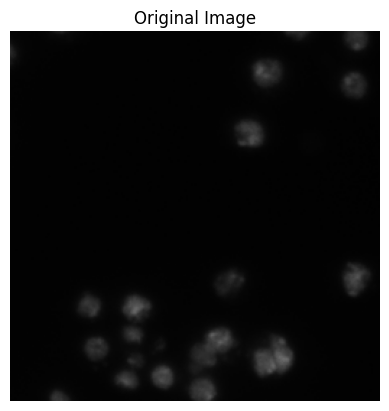

In [43]:
image_path = os.path.join(base_path, sample_id, "images", sample_id + ".png")

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

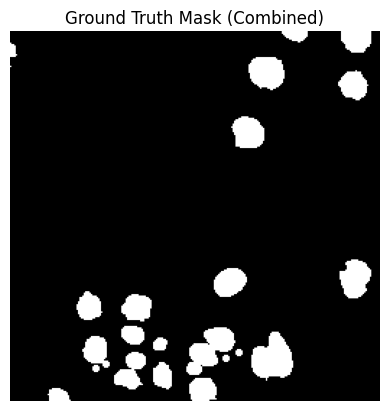

In [44]:
mask_folder = os.path.join(base_path, sample_id, "masks")

mask_files = os.listdir(mask_folder)

combined_mask = np.zeros(img.shape[:2], dtype=np.uint8)

for file in mask_files:
    mask_path = os.path.join(mask_folder, file)
    mask = cv2.imread(mask_path, 0)
    combined_mask = cv2.bitwise_or(combined_mask, mask)

plt.imshow(combined_mask, cmap='gray')
plt.title("Ground Truth Mask (Combined)")
plt.axis("off")
plt.show()

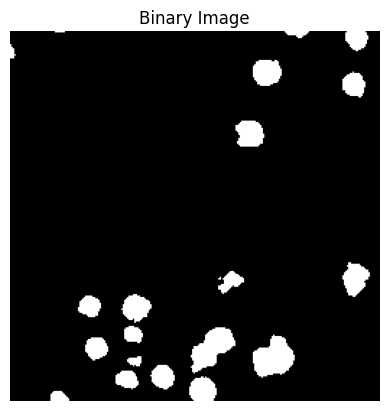

In [45]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# I am using Otsu threshold to convert image to binary
_, thresh = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.imshow(thresh, cmap='gray')
plt.title("Binary Image")
plt.axis("off")
plt.show()

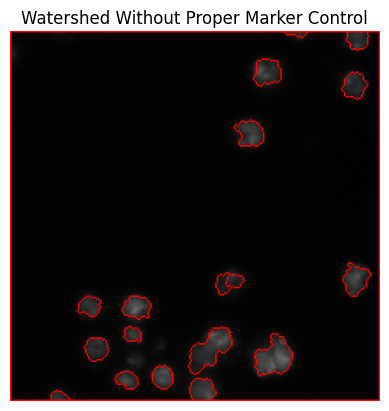

In [46]:
kernel = np.ones((3,3), np.uint8)

sure_bg = cv2.dilate(thresh, kernel, iterations=2)

dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

_, sure_fg = cv2.threshold(dist_transform,
                           0.3 * dist_transform.max(),
                           255, 0)

sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
basic_markers = markers.copy()   # I am saving basic watershed result

basic_result = img.copy()
basic_result[markers == -1] = [255, 0, 0]   # red boundaries

plt.imshow(basic_result)
plt.title("Watershed Without Proper Marker Control")
plt.axis("off")
plt.show()

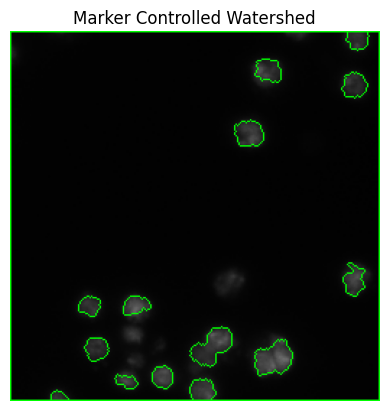

In [47]:
opening = cv2.morphologyEx(thresh,
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening,
                                       cv2.DIST_L2,
                                       5)

_, sure_fg = cv2.threshold(dist_transform,
                           0.5 * dist_transform.max(),
                           255, 0)

sure_fg = np.uint8(sure_fg)

unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)

markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img, markers)
marker_markers = markers.copy()   # I am saving marker-controlled result

marker_result = img.copy()
marker_result[markers == -1] = [0, 255, 0]   # green boundaries

plt.imshow(marker_result)
plt.title("Marker Controlled Watershed")
plt.axis("off")
plt.show()

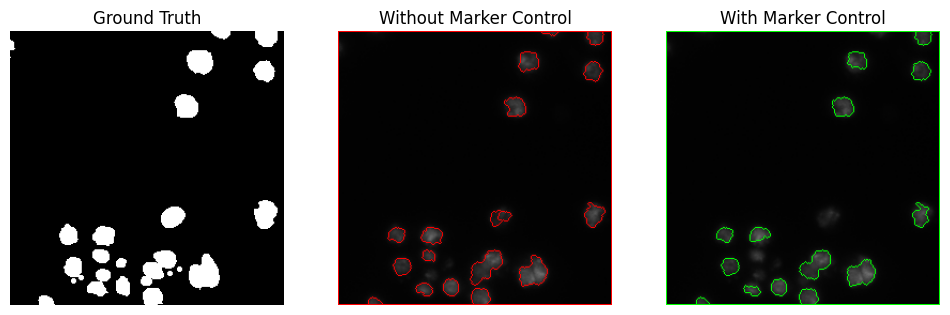

In [48]:
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.imshow(combined_mask, cmap='gray')
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(basic_result)
plt.title("Without Marker Control")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(marker_result)
plt.title("With Marker Control")
plt.axis("off")

plt.show()

In [49]:
# Converting both watershed outputs to binary masks

basic_mask = np.zeros_like(combined_mask)
basic_mask[basic_markers > 1] = 255

marker_mask = np.zeros_like(combined_mask)
marker_mask[marker_markers > 1] = 255


# Dice Score Function 

def dice_score(gt, pred):
    gt = gt > 0
    pred = pred > 0
    
    intersection = np.logical_and(gt, pred).sum()
    return (2.0 * intersection) / (gt.sum() + pred.sum())


# Computing Dice 

dice_basic = dice_score(combined_mask, basic_mask)
dice_marker = dice_score(combined_mask, marker_mask)

print("Dice Score (Without Marker Control):", dice_basic)
print("Dice Score (With Marker Control):", dice_marker)


# Comparing Nuclei Count

true_count = len(mask_files)

basic_count = len(np.unique(basic_markers)) - 2
marker_count = len(np.unique(marker_markers)) - 2

print("\nGround Truth Count:", true_count)
print("Basic Watershed Count:", basic_count)
print("Marker Controlled Count:", marker_count)

Dice Score (Without Marker Control): 0.7229345523469729
Dice Score (With Marker Control): 0.645367412140575

Ground Truth Count: 28
Basic Watershed Count: 18
Marker Controlled Count: 14
